In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim import downloader
import spacy
nlp = spacy.load("en_core_web_sm")

# Sentiment Analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# LDA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LdaMulticore

glove = downloader.load('glove-wiki-gigaword-50')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[==================================================] 100.0% 66.0/66.0MB downloaded


count    19450.000000
mean         0.452842
std          0.484593
min         -0.993200
25%          0.000000
50%          0.624900
75%          0.840200
max          0.999000
Name: sentiment_compound_score, dtype: float64
[(0, '0.022*"staff" + 0.014*"villa" + 0.011*"parcs" + 0.011*"great" + 0.009*"service" + 0.009*"center" + 0.008*"told" + 0.007*"time" + 0.007*"like" + 0.007*"clean"'), (1, '0.109*"staff" + 0.057*"friendly" + 0.051*"helpful" + 0.017*"service" + 0.016*"clean" + 0.012*"polite" + 0.009*"great" + 0.008*"activities" + 0.007*"excellent" + 0.006*"restaurants"'), (2, '0.038*"service" + 0.035*"food" + 0.031*"good" + 0.019*"staff" + 0.013*"time" + 0.009*"parcs" + 0.009*"excellent" + 0.008*"best" + 0.008*"center" + 0.007*"cafe"'), (3, '0.021*"staff" + 0.020*"told" + 0.012*"pool" + 0.009*"asked" + 0.007*"arrived" + 0.007*"pm" + 0.006*"services" + 0.006*"service" + 0.006*"day" + 0.005*"guest"'), (4, '0.021*"staff" + 0.012*"time" + 0.012*"good" + 0.009*"activities" + 0.008*"booked" 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


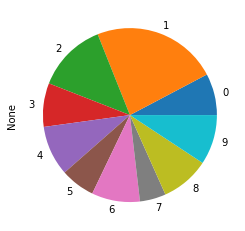

In [ ]:
def sentiment_analysis_preprocessing(df_s):
  df_s['preprocess_data'] = df_s['review_sentence'].apply(lambda x: simple_preprocess(x, deacc=True))
  df_s['preprocess_data'] = df_s['preprocess_data'].apply(' '.join)
  df_s['preprocess_data'] = df_s['preprocess_data'].apply(lambda x: remove_stopwords(x))
  return df_s

def retrieve_reviews_from_specific_topic(topic,df_s,model=glove):

  list_indexes = []
  for i in range(df_s.shape[0]):
      for token in nltk.tokenize.word_tokenize(df_s['preprocess_data'].values[i]):
        try:
          if glove.similarity(topic,token) > 0.7:
            list_indexes.append(i)
            continue    
        except Exception:
          continue

  df_topic = df_s[df_s.index.isin(list_indexes)]

  return df_topic

def sentiment_analysis(df_topic):
  analyser = SentimentIntensityAnalyzer()
  df_topic['sentiment_compound_score'] = df_topic['review_sentence'].map(lambda x: analyser.polarity_scores(x)["compound"])
  print(df_topic['sentiment_compound_score'].describe())
  return df_topic

def train_lda(df_topic,num_topics = 10):
  review_preprocessed = df_topic['preprocess_data'].map(lambda x: nltk.tokenize.word_tokenize(x))
  id2word = corpora.Dictionary(review_preprocessed)
  # Term Document Frequency
  corpus = [id2word.doc2bow(review) for review in review_preprocessed]
  lda_model = LdaMulticore(corpus=corpus,id2word=id2word,num_topics=num_topics)

  topics = []
  for i in range(df_topic.shape[0]):
    topics.append(sorted(lda_model[corpus[i]], key=lambda x: x[1], reverse=True)[0][0])
  df_topic['topics'] = topics

  plot = df_topic.groupby('topics').size()
  plot.plot.pie(figsize=(4,4))

  return df_topic, lda_model

df_s = preprocessing_review_to_sentence(path+'full.json',path+'sentence.csv')
df_s = pd.read_csv(path+'sentence.csv')
df_s = sentiment_analysis_preprocessing(df_s)

topic = "staff"
df_topic = retrieve_reviews_from_specific_topic(topic,df_s,glove)
df_topic = sentiment_analysis(df_topic)
df_topic,lda_model = train_lda(df_topic)

print(df_topic['sentiment_compound_score'].describe())
print(lda_model.print_topics())